# Introduction to Financial Engineering [IE471]
##  Hands-on Practice on Financial AI Session #2

### 1. Import Packages
#### Please import pandas_datareader package using 'pip install pandas_datareader'.

In [1]:
#data preprocessing
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler

#machine learning
import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Pytorch Lightning
import pytorch_lightning as pl 
def dummy_trainloader():
    tl = DataLoader(TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1)
    return tl
trainloader= dummy_trainloader()

# Import from src
import sys; sys.path.append('../')
from src.models import RNN_model, GRU_model, LSTM_model 

# Plot style
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

# declare device
device = torch.device('cpu') 

### 2. Loading the Dataset

#### Loading Sentiment Analysis Results
We modify the dataset to have the polished names

In [2]:
ds_data = pd.read_csv('data/daily_sentiment_scores.csv', index_col=0)
# ds_data = ds_data.iloc[:, 1]
ds_data = ds_data.drop(columns={'sentiment'})
ds_data = ds_data.reset_index(['date'])
ds_data['date'] = pd.to_datetime(ds_data['date'])
ds_data = ds_data.rename(columns={'date': 'Date', 'sentiment_final': 'Sentiment Final'})
ds_data = ds_data.set_index(['Date'])
ds_data.head()

,Sentiment Final
Date,
2020-01-01,0.154961
2020-01-02,0.161528
2020-01-03,0.128297
2020-01-04,0.144796
2020-01-05,0.132267


#### Loading Stock Price Data of Tesla

In [3]:
start = (2020, 1, 2)  # 2020-01-02 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) # 2020-12-31
end_time = datetime.datetime(*end) 

# Loading Samsung Electronic Co,. Ltd. (KS: 005930) Data from Yahoo Finance
df = pdr.DataReader('TSLA', 'yahoo', start_time, end_time)

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001


In [5]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,666.090027,641.000000,642.98999,661.770020,22865600.0,661.770020
2020-12-28,681.400024,660.799988,674.51001,663.690002,32278600.0,663.690002
2020-12-29,669.900024,655.000000,661.00000,665.989990,22910800.0,665.989990
2020-12-30,696.599976,668.359985,672.00000,694.780029,42846000.0,694.780029
2020-12-31,718.719971,691.119995,699.98999,705.669983,49649900.0,705.669983


In [6]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001
...,...,...,...,...,...,...
2020-12-24,666.090027,641.000000,642.989990,661.770020,22865600.0,661.770020
2020-12-28,681.400024,660.799988,674.510010,663.690002,32278600.0,663.690002
2020-12-29,669.900024,655.000000,661.000000,665.989990,22910800.0,665.989990


In [7]:
df_rv = pd.merge(df, ds_data, on='Date') #Add sentiment analysis results in trading days #, left_index=True, right_index=True
df_rv.head()

,High,Low,Open,Close,Volume,Adj Close,Sentiment Final
Date,,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,0.161528
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,0.128297
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,0.117547
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,0.104325
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001,0.123884


In [8]:
X = df_rv # Using high price, low price, Open price, Close price, Volume, Adjusted Close Price, Sentiment Analysis Results to predict adjusted close price
y = df_rv.iloc[:, 5:6] #Predicting adjusted close price

### 3. Scaling and Converting Data (With Sentiment Analysis Results)

We can see that there is a big difference between volume and other values. In this case, LSTM models need to recognize the difference between these two scales: volume and the rest values, which can be a burden to train data. Therefore, we reduce by scaling all variables from 0 to 1 to reduce the burden on the model.

In [9]:
MMS = MinMaxScaler()

X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

# Input Variables (7 variables)
X_train = X_data[:188, :] #We trained January - September data including high price, low price, open price, close price, volume, and adj close data
X_test = X_data[188:252, :] #To verify trained model, we used October - December data as the test set

# Output Variables (adjusted close price)
y_train = y_data[1:189, :]
y_test = y_data[189:, :] 

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape) 

Training Set Shape (188, 7) (188, 1)
Testing Set Shape (64, 7) (64, 1)


In [10]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([188, 1, 7]) torch.Size([188, 1])
Testing Shape torch.Size([64, 1, 7]) torch.Size([64, 1])


We import from src/ in order to have a better organization
### 4a. Building RNN Model

In [11]:
?? RNN_model

Init signature:  RNN_model(num_classes, input_size, hidden_size, num_layers, seq_length)
Source:        
class RNN_model(nn.Module):
    '''Recurrent Neural Network model'''
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(RNN_model, self).__init__()
        self.RNN_model = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #RNN layer
        self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x) #hidden state
        # Propagate input through RNN
        out, _ = self.rnn(x, h0)  # out: tensor of shape 

### 4b. Building GRU Model

In [12]:
?? GRU_model

Init signature:  GRU_model(num_classes, input_size, hidden_size, num_layers, seq_length)
Source:        
class GRU_model(nn.Module):
    '''Gated Recurrent Unit model'''
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU_model, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #GRU layer
        self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x) #hidden state
        # Propagate input through GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (b

### 4c. Building LSTM Model

In [13]:
?? LSTM_model

Init signature:  LSTM_model(num_classes, input_size, hidden_size, num_layers, seq_length)
Source:        
class LSTM_model(nn.Module):
    '''Long Short Term Memory model'''
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_model, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x) #hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x) #in

### 4d. Pytorch Lightning Model
We build the PL model to be as concise and clear as possible

In [14]:
class LitTimeSeriesModule(pl.LightningModule):
    def __init__(self, model_type='LSTM'):
        super().__init__()
        if model_type == 'LSTM':
            self.model = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
        elif model_type == 'GRU':
            self.model = GRU_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
        elif model_type == 'RNN':
            self.model = RNN_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
        else: raise NotImplementedError('Available models: LSTM, GRU')
        self.loss = torch.nn.MSELoss() 

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        out = self(X_train_tensors_final.to(device))
        loss = self.loss(out, y_train_tensors.to(device))        
        self.log('train_loss', loss)
        return loss
    
    def validation_step():
        out = self(X_test_tensors_final.to(device))
        val_loss = self.loss(out, y_test_tensors.to(device))
        self.log('val_loss', val_loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def train_dataloader(self):
        return trainloader

### 5a. Setting Hyperparameters and Training Data

In [15]:
num_epochs = 10000
learning_rate = 0.001

input_size = 7 # number of features (+ Add Sentiment Analysis Results)
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers
num_classes = 1 #number of output classes 

### 5b. Training with Pytorch Lightning
Pytorch Lightning introduces a very low overhead, which is more evident in this case due to the small dataset

#### RNN Model

In [16]:
rnn = LitTimeSeriesModule(model_type='RNN')
trainer = pl.Trainer(max_epochs=num_epochs)
trainer.fit(rnn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | RNN_model | 25    
1 | loss  | MSELoss   | 0     
------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

1

#### GRU Model

In [17]:
gru = LitTimeSeriesModule(model_type='GRU')
trainer = pl.Trainer(max_epochs=num_epochs)
trainer.fit(gru)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | GRU_model | 69    
1 | loss  | MSELoss   | 0     
------------------------------------
69        Trainable params
0         Non-trainable params
69        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

1

#### LSTM Model

In [18]:
lstm = LitTimeSeriesModule(model_type='LSTM')
trainer = pl.Trainer(max_epochs=num_epochs)
trainer.fit(lstm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | LSTM_model | 91    
1 | loss  | MSELoss    | 0     
-------------------------------------
91        Trainable params
0         Non-trainable params
91        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

1

### 6. Results
We will compare:
1. LSTM model without and with sentiment analysis
2. RNN, GRU and LSTM models with sentiment analysis

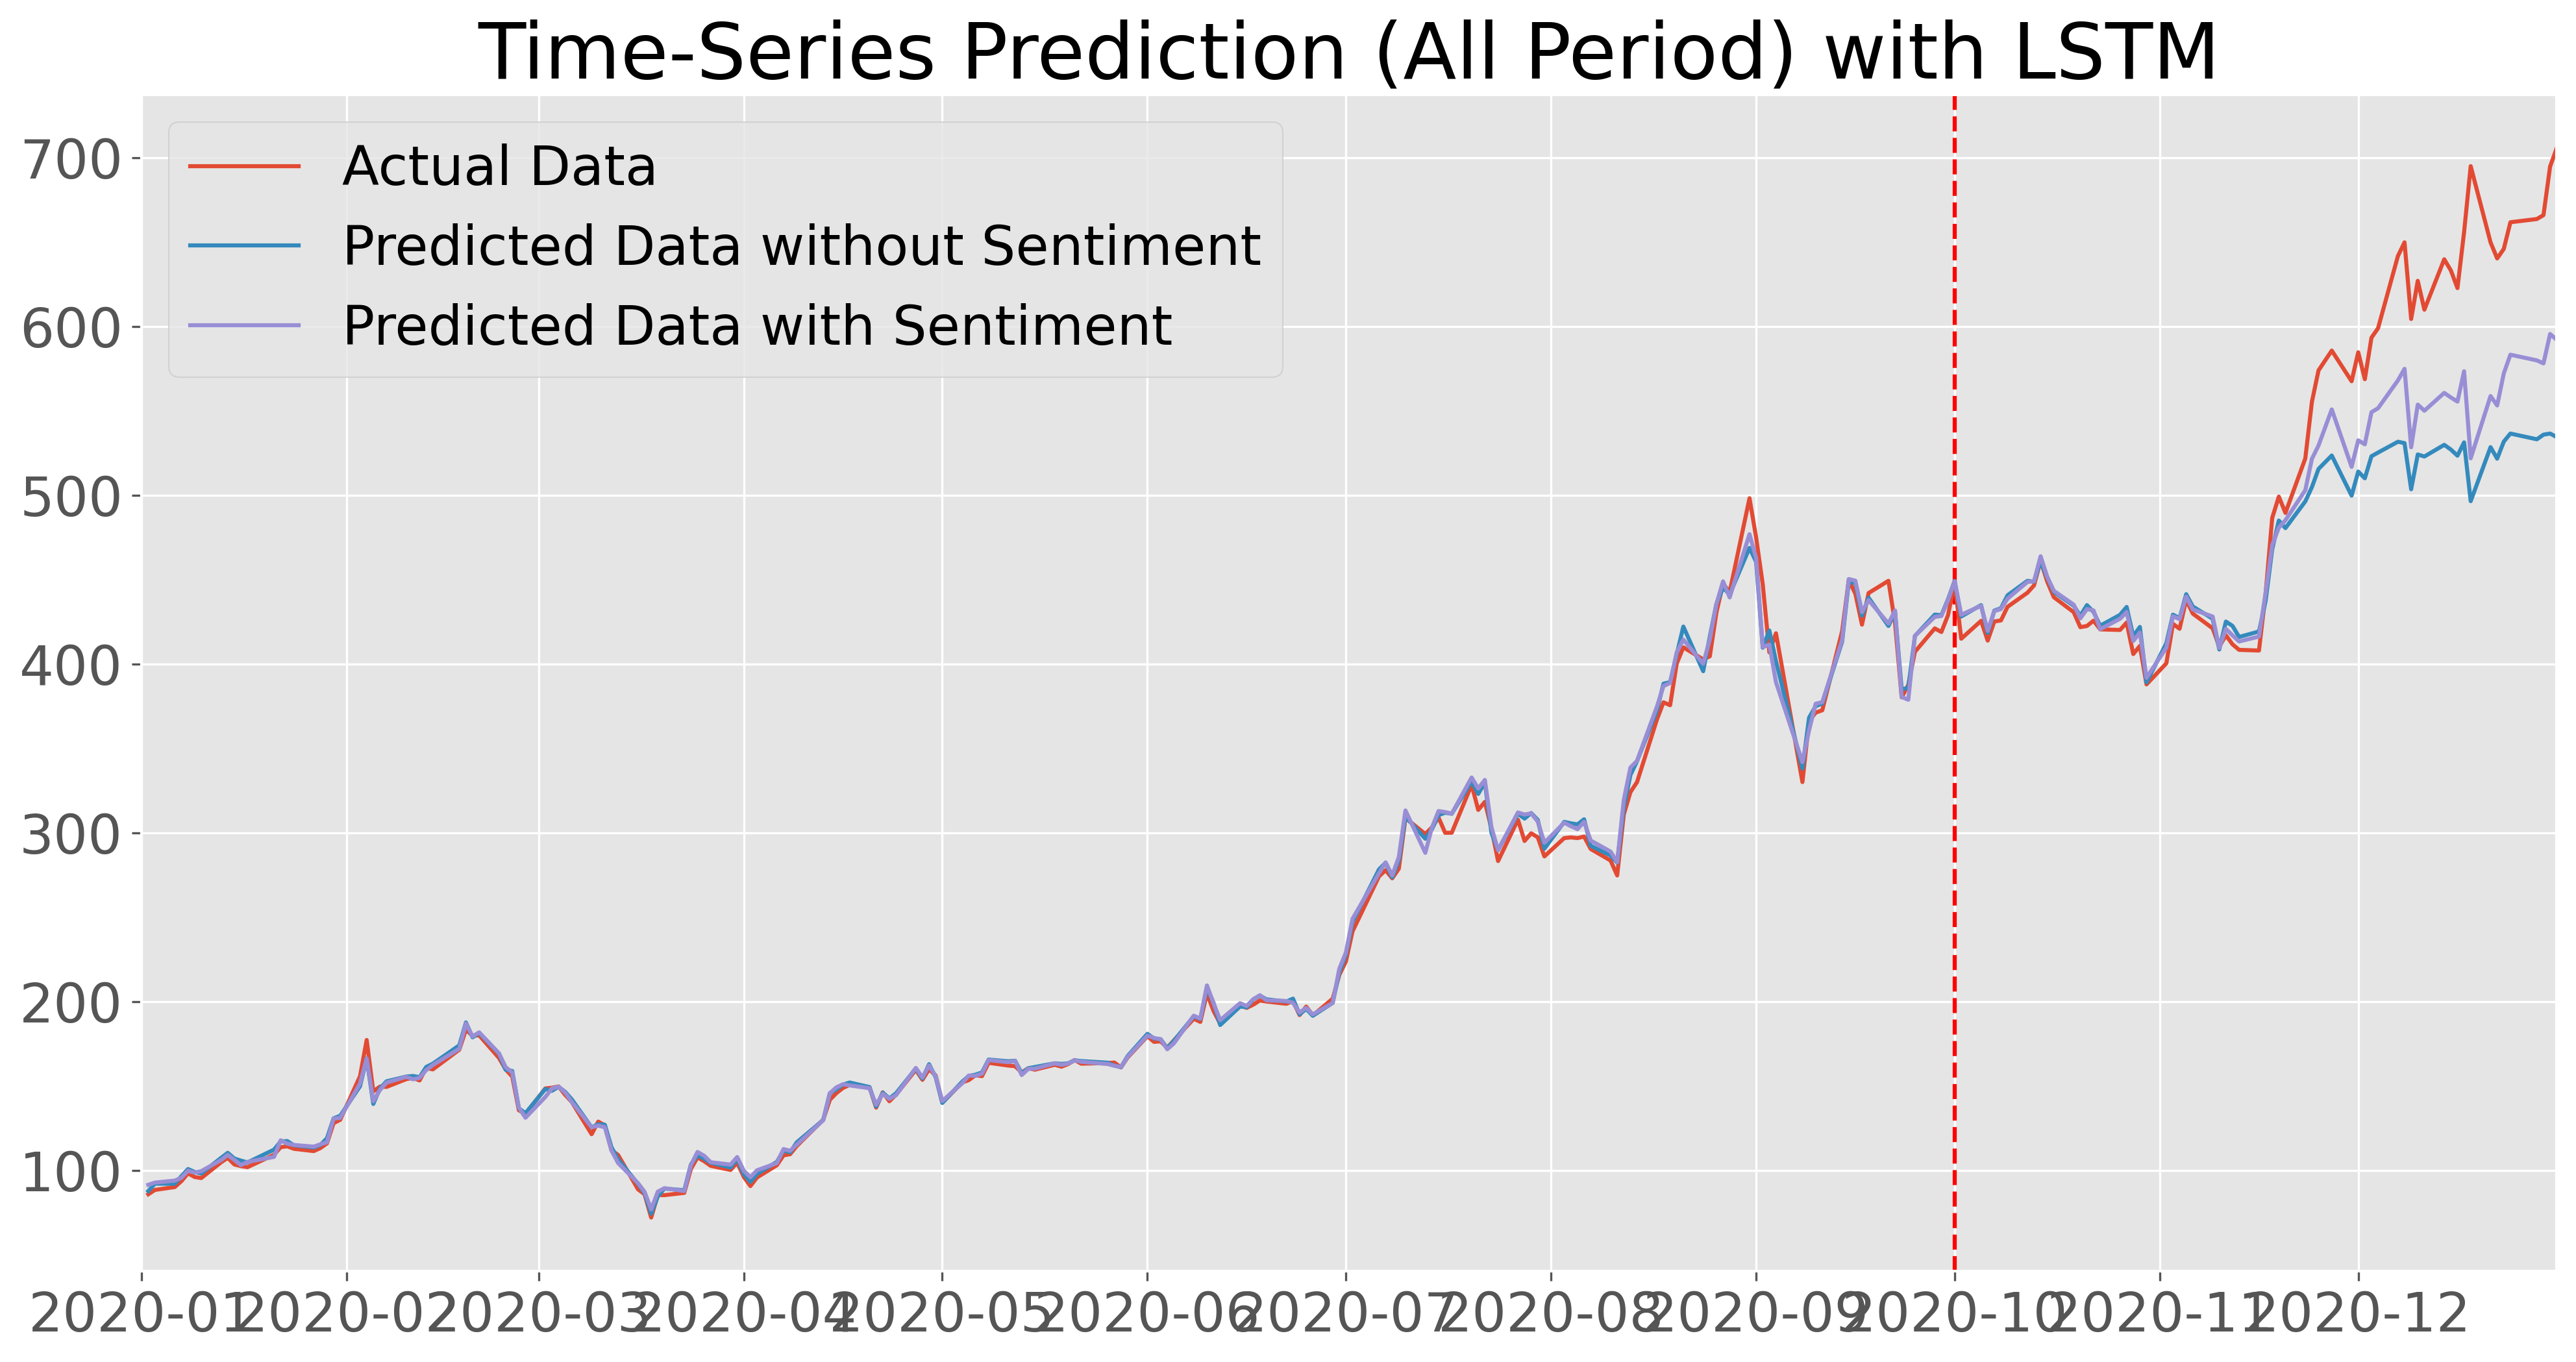

In [28]:
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
dataY_plot = df_y.data.numpy()
dataY_plot = MMS.inverse_transform(dataY_plot)

# 1. LSTM without sentiment analysis
lstm_no_sentiment = torch.load('saved_models/tesla_lstm.pt')
train_predict = lstm_no_sentiment(df_X[..., :6].to(device)) #forward pass without sentiment
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
lstm_no_sentiment_prediction = MMS.inverse_transform(data_predict) #reverse transformation

# 2. Comparisons with sentiment
# RNN
train_predict = rnn(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
rnn_prediction = MMS.inverse_transform(data_predict) #reverse transformation

# GRU
train_predict = gru(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
gru_prediction = MMS.inverse_transform(data_predict) #reverse transformation

# LSTM
train_predict = lstm(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
lstm_prediction = MMS.inverse_transform(data_predict) #reverse transformation

plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2020, 10, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), lstm_no_sentiment_prediction, label='Predicted Data without Sentiment') # plot for predicted data
plt.plot(df.index.to_pydatetime(), lstm_prediction, label='Predicted Data with Sentiment') # plot for predicted data
plt.title('Time-Series Prediction (All Period) with LSTM')
plt.legend()
plt.savefig('images/lstm_with_without_sentiment_all.pdf', bbox_inches='tight')
plt.show()

In [20]:
MSE = float(sum((dataY_plot - lstm_prediction)*(dataY_plot - lstm_prediction))/len(lstm_prediction))
print('Mean Squared Error:', MSE)

Mean Squared Error: 669.5746459960938


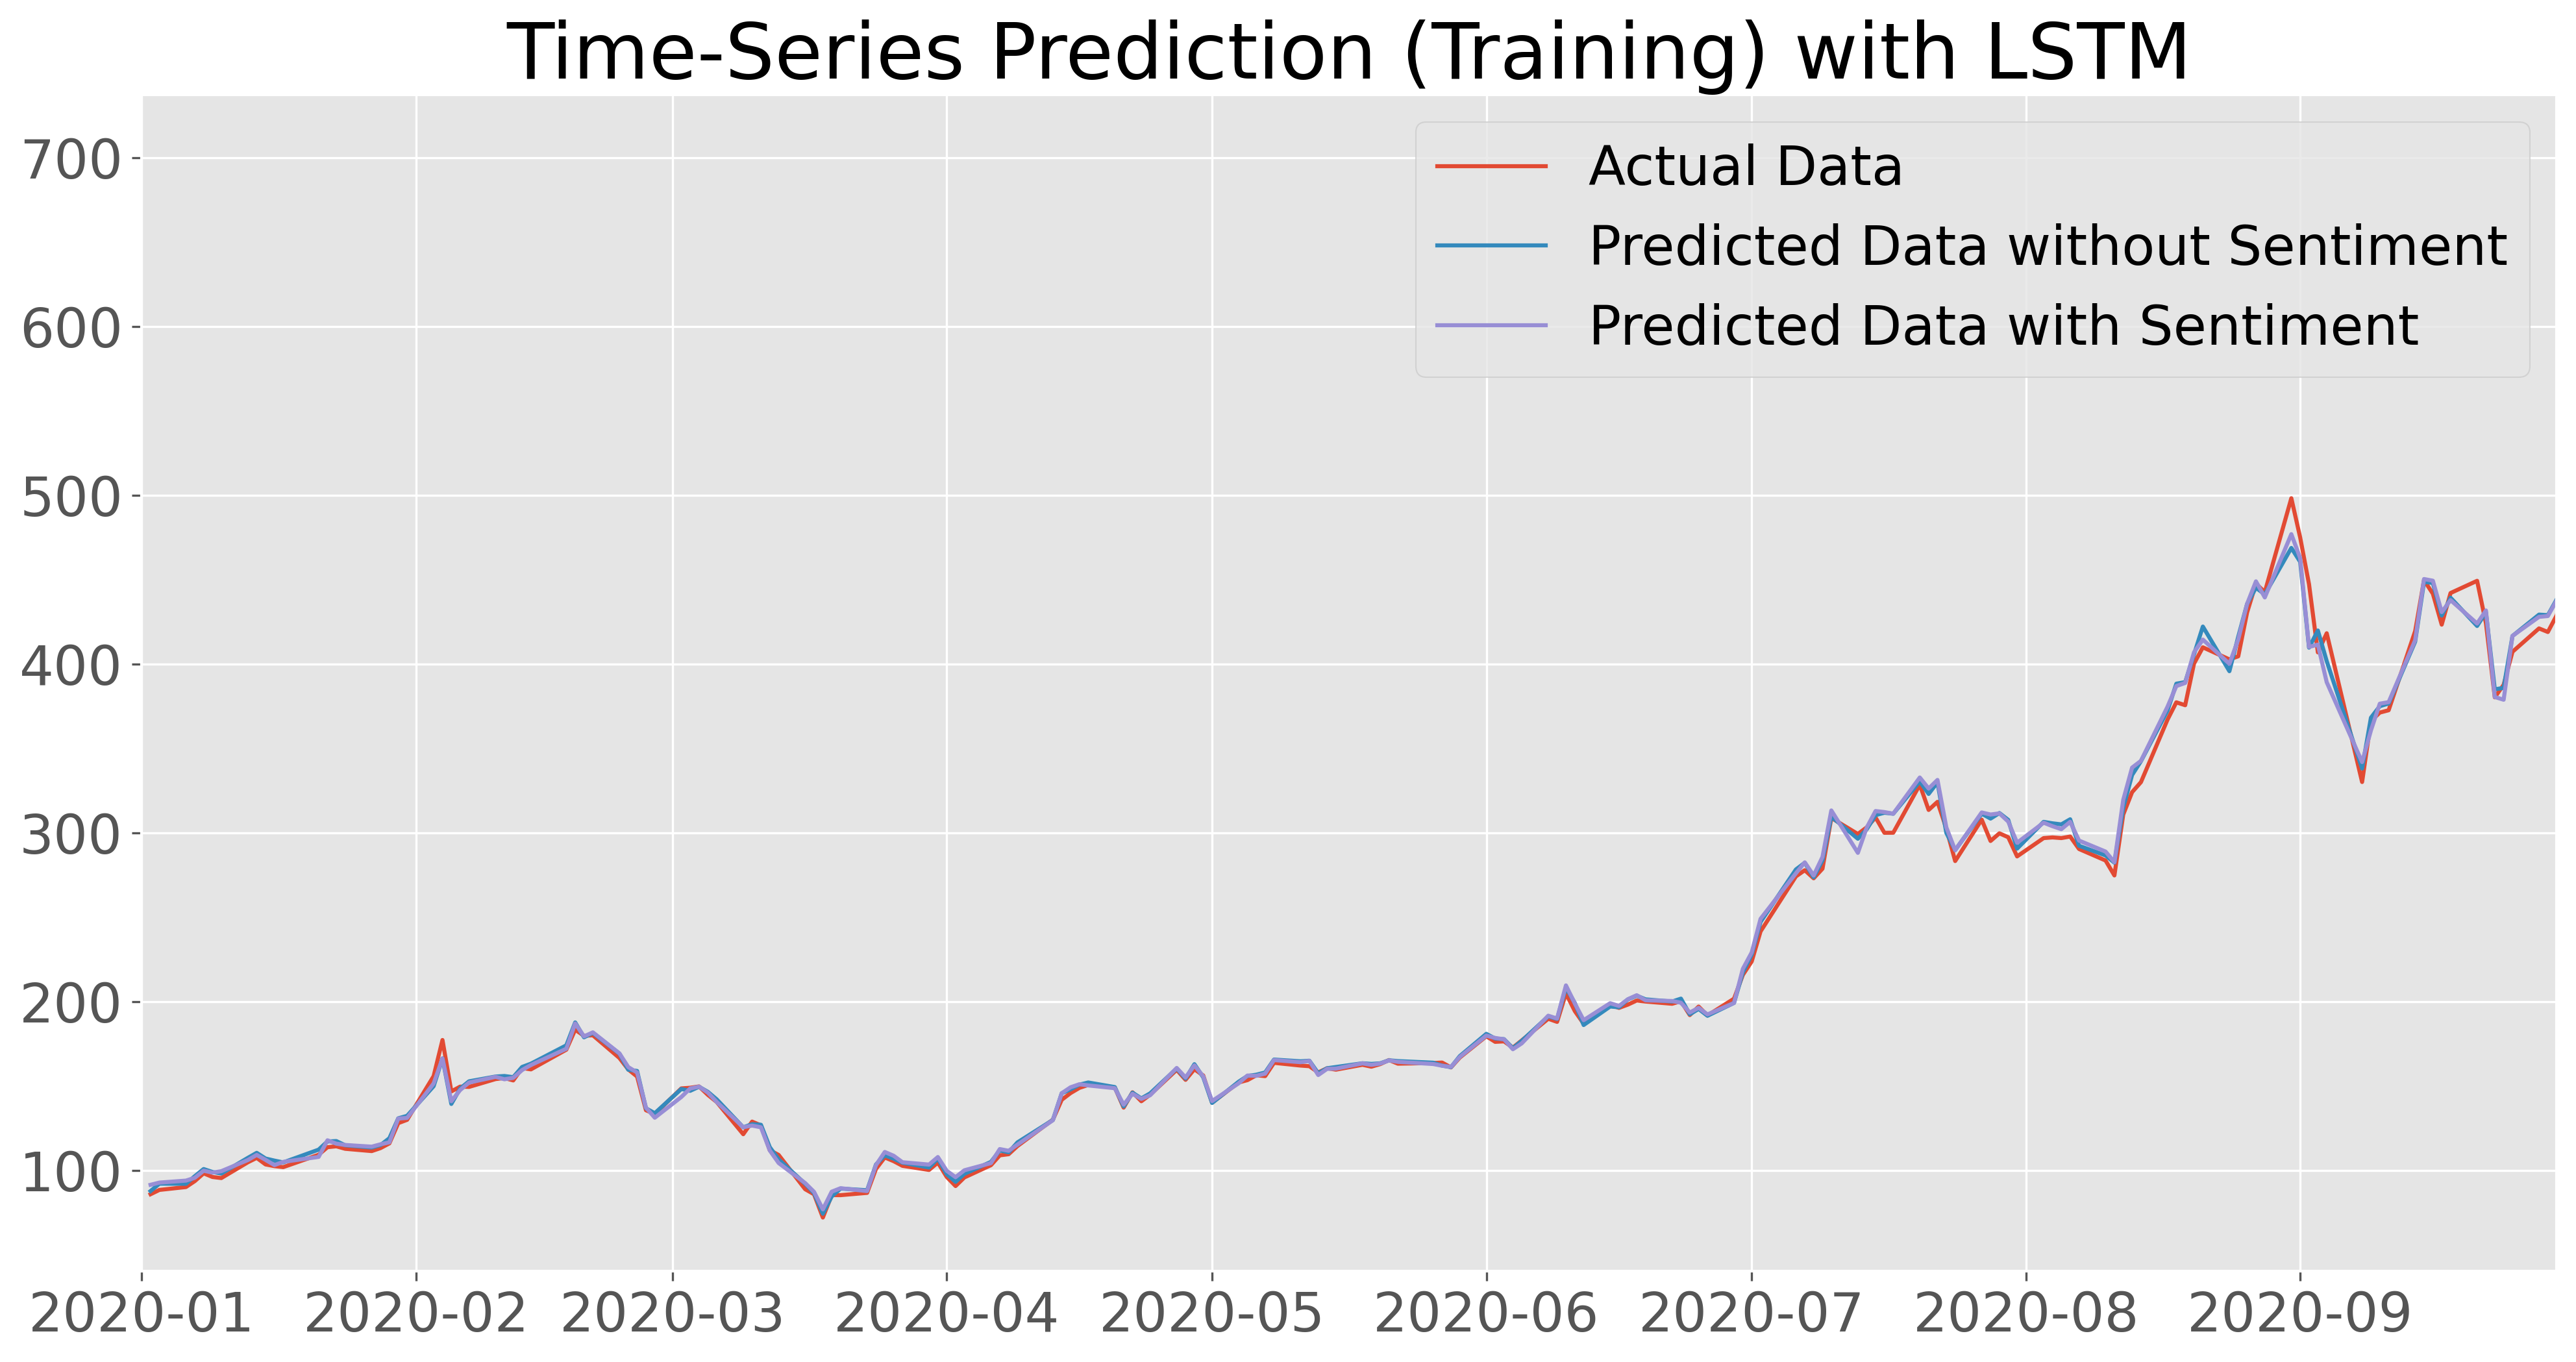

In [27]:
plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 9, 30))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), lstm_no_sentiment_prediction, label='Predicted Data without Sentiment') # plot for predicted data
plt.plot(df.index.to_pydatetime(), lstm_prediction, label='Predicted Data with Sentiment') # plot for predicted data
plt.title('Time-Series Prediction (Training) with LSTM')
plt.legend()
plt.savefig('images/lstm_with_without_sentiment_training.pdf', bbox_inches='tight')
plt.show()

In [22]:
MSE_train = float(sum((dataY_plot[0:188] - lstm_prediction[0:188])*(dataY_plot[0:188] - lstm_prediction[0:188]))/len(lstm_prediction[0:189]))
print('Mean Squared Error (Training Data):', MSE_train)

Mean Squared Error (Training Data): 42.07353973388672


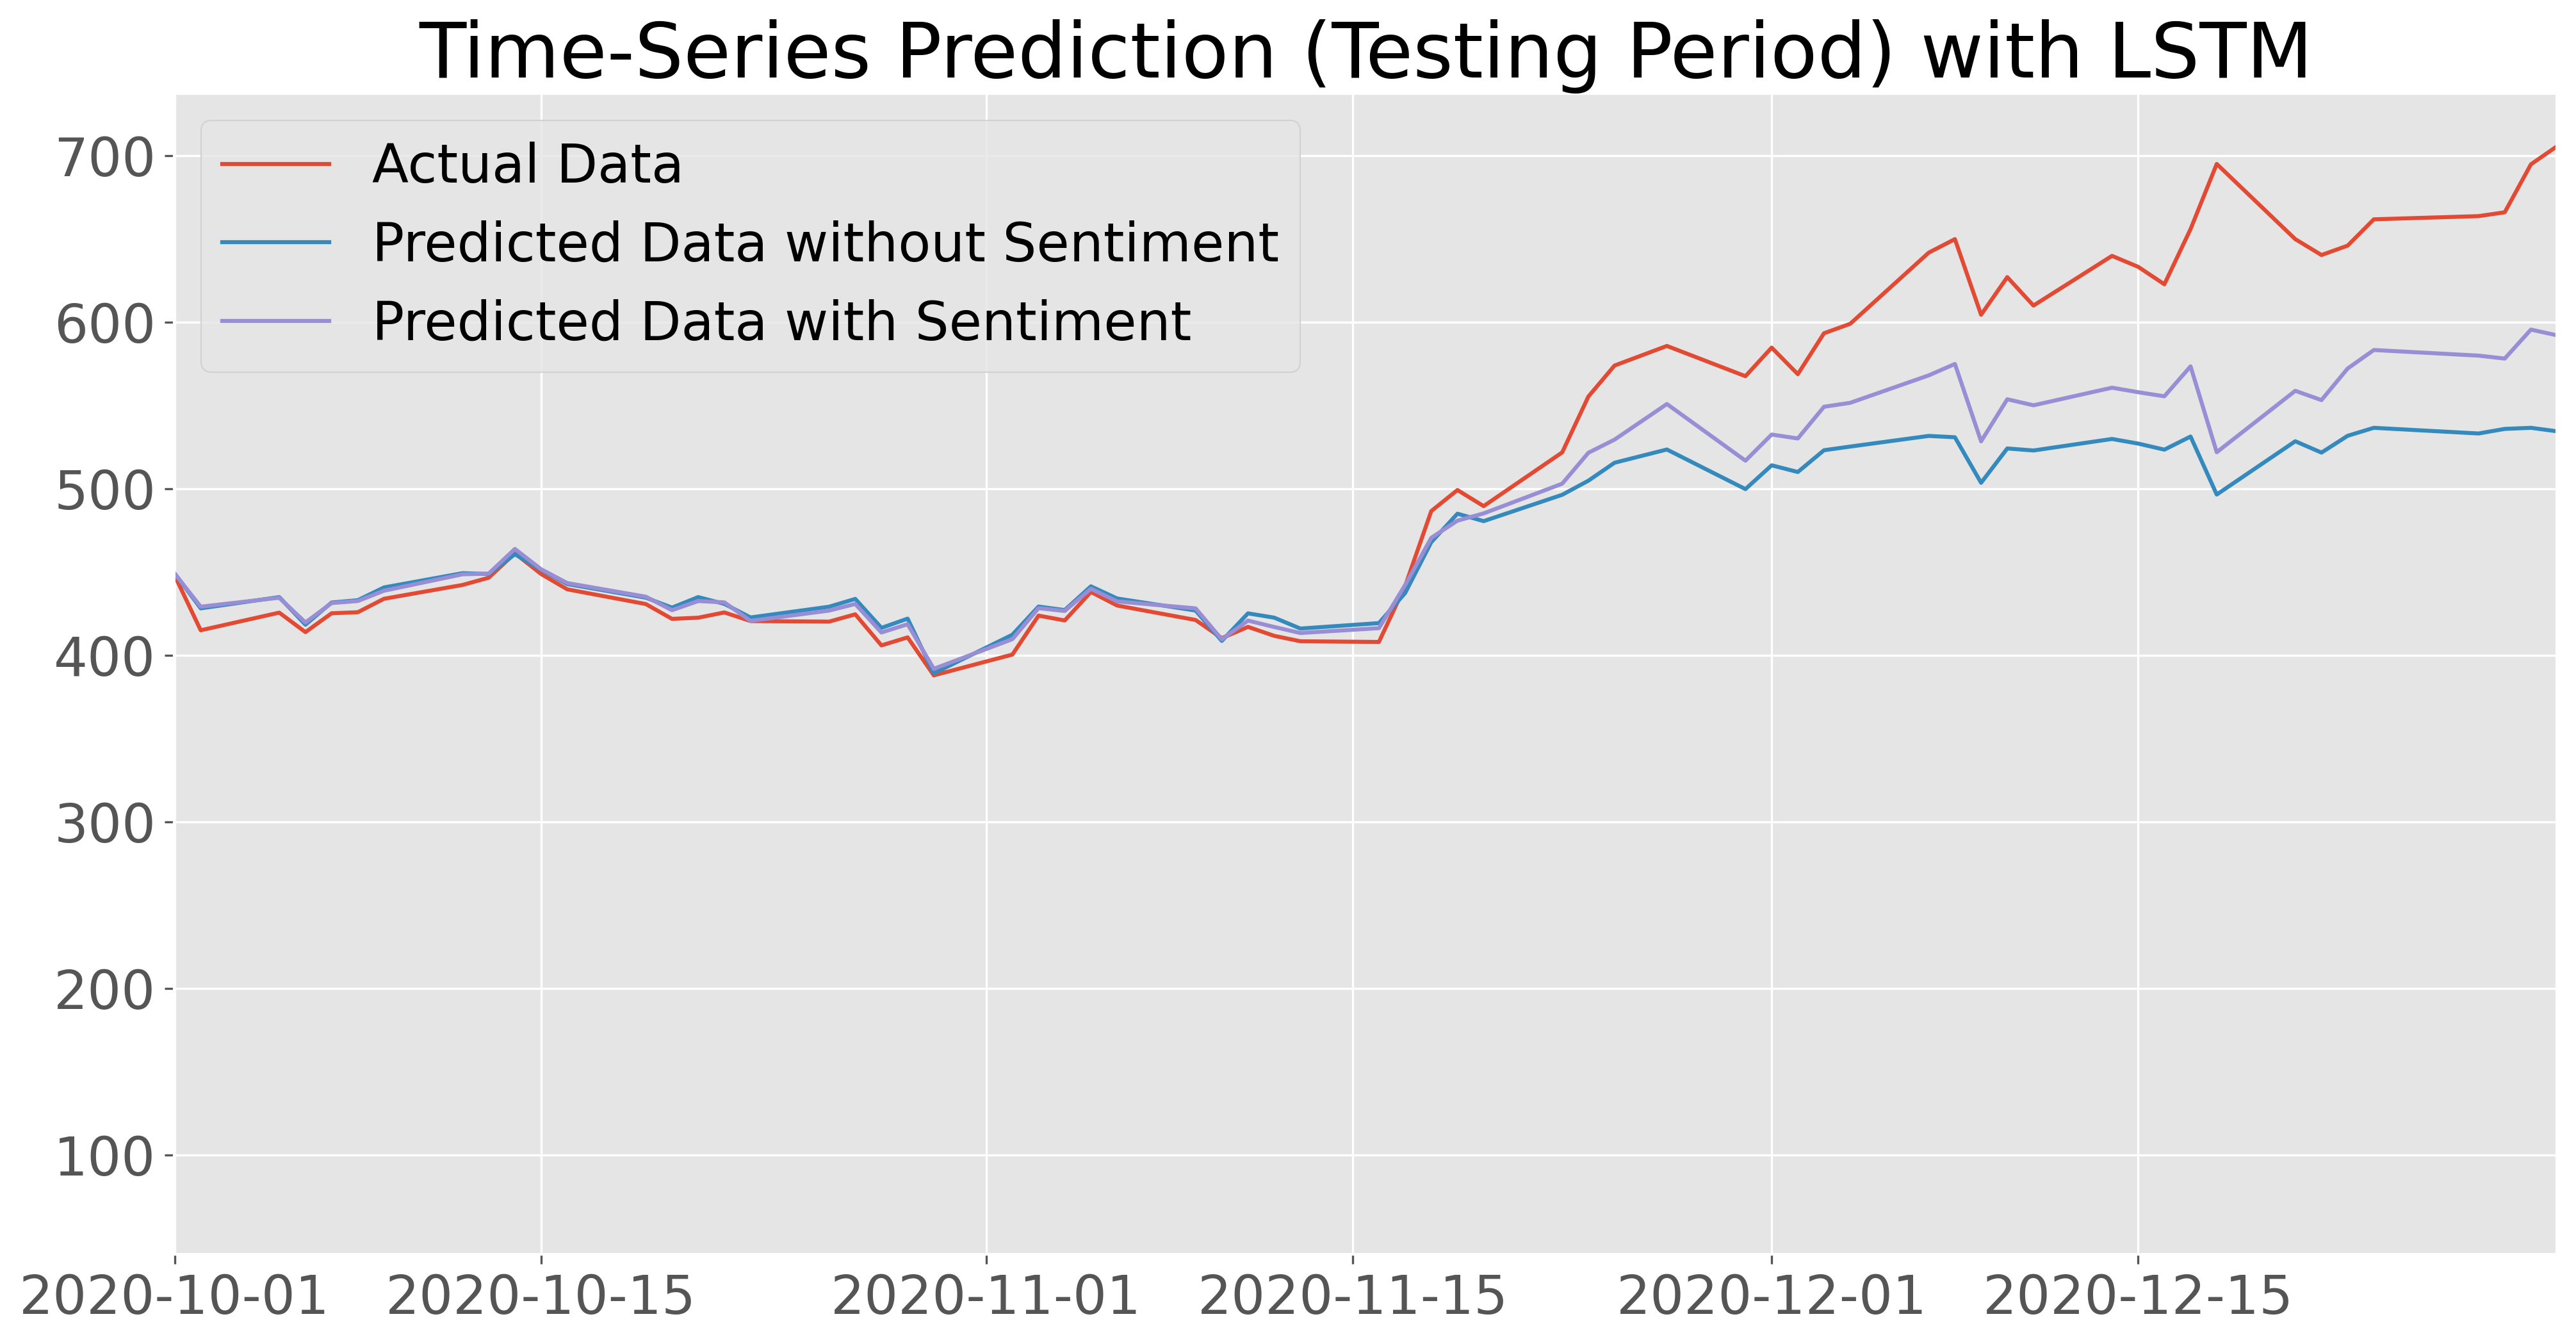

In [29]:
plt.xlim(datetime.datetime(2020, 10, 1), datetime.datetime(2020, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), lstm_no_sentiment_prediction, label='Predicted Data without Sentiment') # plot for predicted data
plt.plot(df.index.to_pydatetime(), lstm_prediction, label='Predicted Data with Sentiment') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period) with LSTM')
plt.legend()
plt.savefig('images/lstm_with_without_testing.pdf', bbox_inches='tight')
plt.show()

In [24]:
MSE_test = float(sum((dataY_plot[188:] - lstm_prediction[188:])*(dataY_plot[188:] - lstm_prediction[188:]))/len(lstm_prediction[188:]))
print('Mean Squared Error (Test Data):', MSE_test)

Mean Squared Error (Test Data): 2483.853515625


### 7. Comparing Different Algorithms

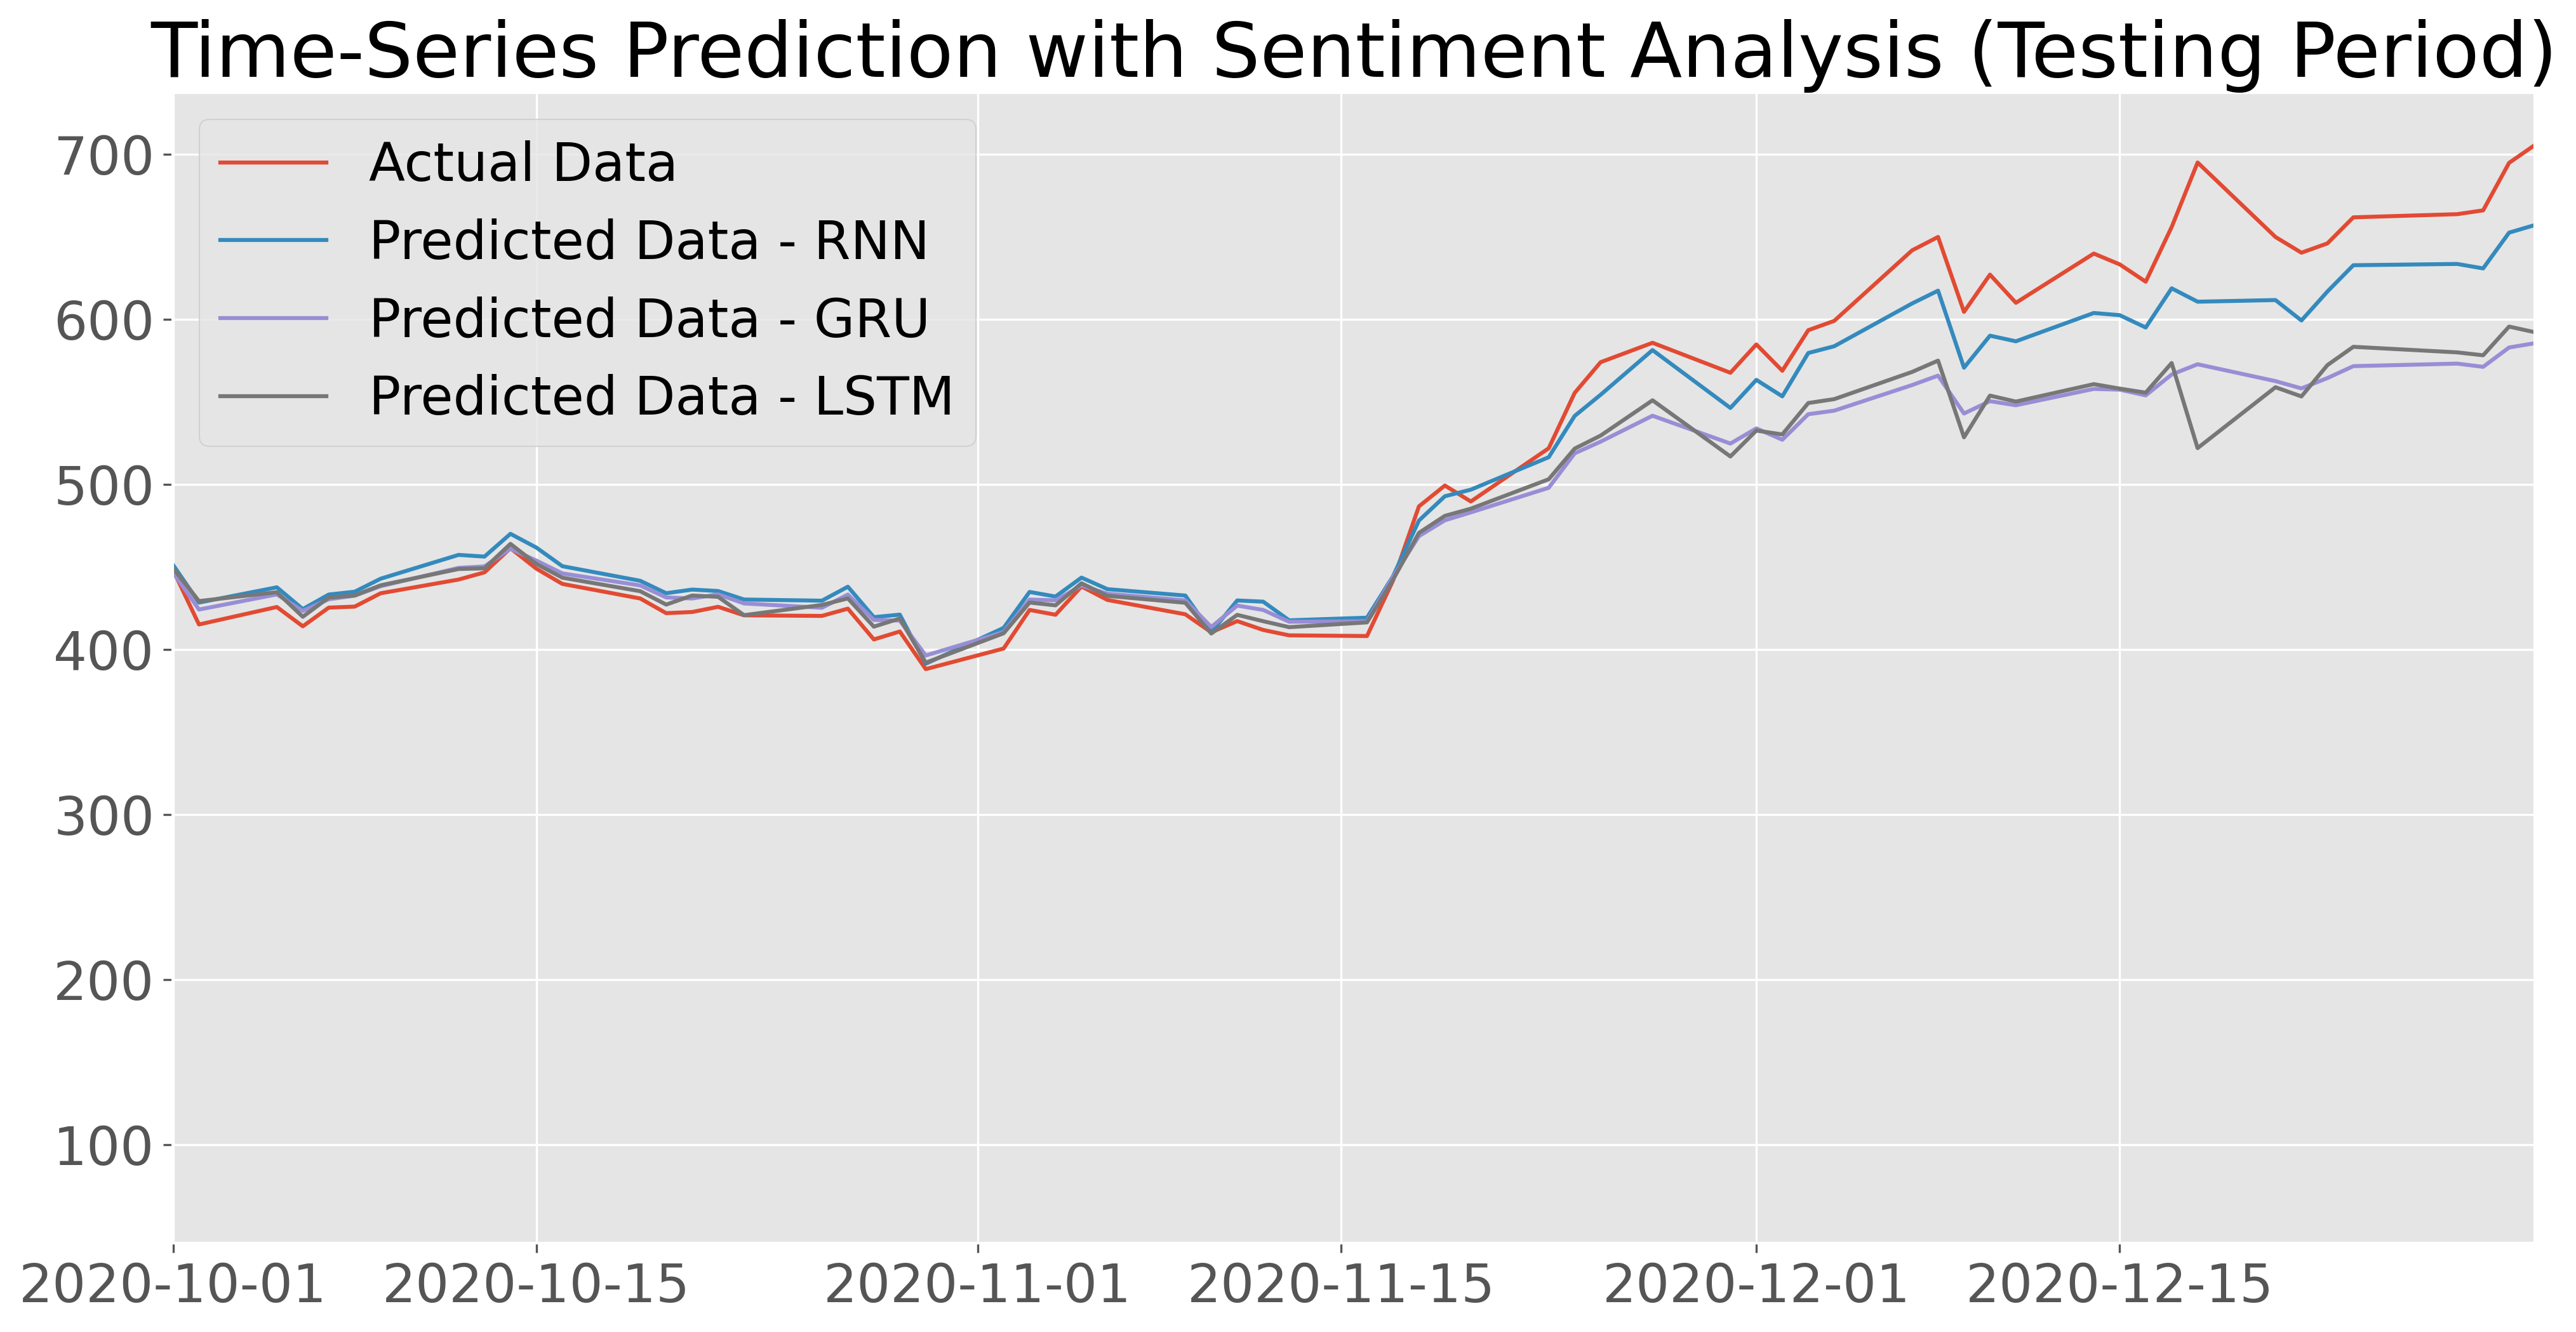

In [30]:
plt.xlim(datetime.datetime(2020, 10, 1), datetime.datetime(2020, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), rnn_prediction, label='Predicted Data - RNN') # plot for predicted data
plt.plot(df.index.to_pydatetime(), gru_prediction, label='Predicted Data - GRU') # plot for predicted data
plt.plot(df.index.to_pydatetime(), lstm_prediction, label='Predicted Data - LSTM') # plot for predicted data
plt.title('Time-Series Prediction with Sentiment Analysis (Testing Period)')
plt.savefig('images/lstm_with_without_all.pdf', bbox_inches='tight')
plt.legend()
plt.savefig('images/comparison.pdf', bbox_inches='tight')
plt.show()

#### MSE comparisons

In [37]:
def calculate_MSE(y_hat, y):
    return float(sum((y_hat - y)**2/len(y)))

print('MSE RNN\nAll = {:.4f}\nTraining = {:.4f}\nTest = {:.4f}\n'.format( 
      calculate_MSE(dataY_plot, rnn_prediction),
      calculate_MSE(dataY_plot[0:188], rnn_prediction[0:188]),
      calculate_MSE(dataY_plot[188:], rnn_prediction[188:])))

print('MSE GRU\nAll = {:.4f}\nTraining = {:.4f}\nTest = {:.4f}\n'.format( 
      calculate_MSE(dataY_plot, gru_prediction),
      calculate_MSE(dataY_plot[0:188], gru_prediction[0:188]),
      calculate_MSE(dataY_plot[188:], gru_prediction[188:])))

print('MSE LSTM\nAll = {:.4f}\nTraining = {:.4f}\nTest = {:.4f}\n'.format( 
      calculate_MSE(dataY_plot, lstm_prediction),
      calculate_MSE(dataY_plot[0:188], lstm_prediction[0:188]),
      calculate_MSE(dataY_plot[188:], lstm_prediction[188:])))

MSE RNN
All = 156.5683
Training = 29.5203
Test = 524.0301

MSE GRU
All = 657.3547
Training = 26.7311
Test = 2481.3120

MSE LSTM
All = 669.5747
Training = 42.2973
Test = 2483.8538

